# Decipher modifications 






## Structure of the variational family


Variational family factorizes into 
$\begin{eqnarray*}
q_{\mathtt{joint}} := q(v_s, v_x, z_x, z_y, z_s) & = & \prod_{i=1}^N q(v_{s,i}, v_{x,i}, z_{x,i}, z_{y,i}, z_{s,i}) \\
q(v_{s,i}, v_{x,i}, z_{x,i}, z_{y,i}, z_{s,i}) & = & q(v_{x,i}|z_{x,i},z_{s,i}) \times q(z_{x,i},z_{s,i}|x_i) \times q(v_{s,i}|z_{s,i},  z_{y,i}) \times q(z_{s,i}|y_i) \times q(z_{y,i}|y_i)
\end{eqnarray*}$ 


Set
- $q(v_{x,i}|z_{x,i},z_{s,i}) = \mathcal{N}(d^{\rightarrow v_x}_{\mathtt{mean}}(z_{x,i}, z_{s,i}), d^{\rightarrow v_x}_{\mathtt{var}}(z_{x,i}, z_{s,i}))$
- $q(v_{s,i}|z_{y,i},z_{s,i}) = \mathcal{N}(d^{\rightarrow v_s}_{\mathtt{mean}}(z_{y,i}, z_{s,i}), d^{\rightarrow v_s}_{\mathtt{var}}(z_{y,i}, z_{s,i}))$
- $q(z_{x,i},z_{s,i}|x_i) = \mathcal{N}(d^{\rightarrow z_{s,x}}_{\mathtt{mean}}(x_i), d^{\rightarrow z_{s,x}}_{\mathtt{var}}(x_i))$
- $q(z_{s,i}|y_i) = \mathcal{N}(d^{\rightarrow z_{s,y}}_{\mathtt{mean}}(y_i), d^{\rightarrow z_{s,y}}_{\mathtt{var}}(y_i))$
- $q(z_{y,i}|y_i) = \mathcal{N}(d^{\rightarrow z_{y}}_{\mathtt{mean}}(y_i), d^{\rightarrow z_{y}}_{\mathtt{var}}(y_i))$

Variational inference objective:

$\begin{eqnarray} 
& \mathcal{L}_{\text{ELBO}}(q)  = \sum_{i=1}^{N} \mathbb{E}_{q_{\mathtt{joint}} }\bigg( \sum_g \log p(x_{i,g}|z_{s,i}, z_{x,i}, \theta_g) + \log \frac{p(z_{s,i}, z_{x,i}|v_{x,i}, v_{s,i})}{q(z_{x,i}, z_{s,i}|x_{i,g})} + \beta_x \log \frac{p(v_{x,i})}{q(v_{x,i}|z_{x,i},z_{s,i})}  \\
& + \sum_t  \log p(y_{i,t}|z_{s,i}, z_{y,i}, \eta_t) + \log \frac{p(z_{s,i}, z_{y,i}|v_{s,i})}{q(z_{y,i}, z_{s,i}|y_{i,t})} + \beta_s \log \frac{p(v_{s,i})}{q(v_{s,i}|z_{y,i},z_{s,i})} \bigg)
\end{eqnarray}$

$v \in \mathbb{R}^2, z \in \mathbb{R}^{10}, x, y \in \mathbb{R}^{2000}$

### Decipher module adapted for ATAC

In [10]:
import dataclasses
from dataclasses import dataclass
from typing import Sequence, Union

import numpy as np
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import torch.nn as nn
import torch.utils.data
from torch.distributions import constraints
from torch.nn.functional import softmax, softplus


In [15]:
# pip install randomname

In [11]:
#help(pyro.param)

In [22]:
import decipher

# Testing on PDAC data

In [26]:
import scipy as sp
from decipher.tools._decipher import Decipher_with_ATAC, DecipherConfig_withATAC
from decipher.tools.decipher import decipherATAC_train

In [31]:
pdac_atac = sc.read_h5ad("/Users/clairehe/Documents/GitHub/decipher_with_ATAC/data/pdac_atac.h5ad")
pdac_atac.X = sp.sparse.csr_matrix(pdac_atac.X)

In [32]:
pdac_rna = sc.read_h5ad("/Users/clairehe/Documents/GitHub/decipher_with_ATAC/data/pdac_rna.h5ad")
pdac_rna.X = sp.sparse.csr_matrix(pdac_rna.X)

In [33]:
pdac_rna

AnnData object with n_obs × n_vars = 3988 × 21821
    obs: 'orig.ident', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nCount_ATAC', 'nFeature_ATAC', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'pct_reads_in_peaks', 'blacklist_ratio', 'ATAC_snn_res.1.2', 'seurat_clusters', 'predicted.id', 'prediction.score.B.cell', 'prediction.score.Endothelial', 'prediction.score.Ductal', 'prediction.score.T.cell', 'prediction.score.Epi.Immune', 'prediction.score.Proliferating', 'prediction.score.Tumor.1', 'prediction.score.Macrophage', 'prediction.score.Acinar', 'prediction.score.Fibr

In [34]:
pdac_atac

AnnData object with n_obs × n_vars = 3988 × 258561
    obs: 'orig.ident', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nCount_ATAC', 'nFeature_ATAC', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'pct_reads_in_peaks', 'blacklist_ratio', 'ATAC_snn_res.1.2', 'seurat_clusters', 'predicted.id', 'prediction.score.B.cell', 'prediction.score.Endothelial', 'prediction.score.Ductal', 'prediction.score.T.cell', 'prediction.score.Epi.Immune', 'prediction.score.Proliferating', 'prediction.score.Tumor.1', 'prediction.score.Macrophage', 'prediction.score.Acinar', 'prediction.score.Fib

2023-12-01 15:05:15,130 | INFO : Added `.obs['decipher_split']`: the Decipher train/validation split.
 398 cells in validation set.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
2023-12-01 15:05:15,143 | INFO : Added `.obs['decipher_split']`: the Decipher train/validation split.
 398 cells in validation set.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


V5


Epoch 0 | train elbo: 67546.78 | val ll: 18279.29:   0%|          | 0/100 [02:38<?, ?it/s]2023-12-01 15:09:24,576 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:09:24,579 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/sca

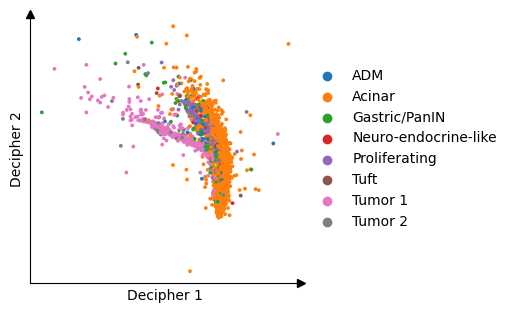

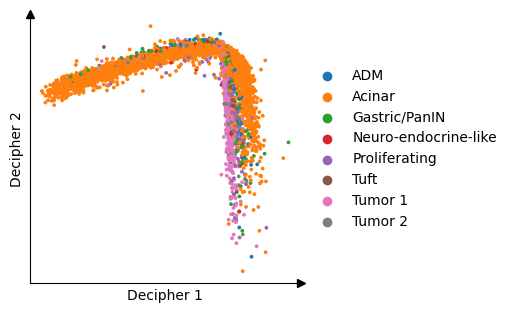

Epoch 1 | train elbo: 61889.16 | val ll: 17929.73:   1%|          | 1/100 [07:14<6:50:48, 248.97s/it]2023-12-01 15:12:48,612 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:12:48,616 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-p

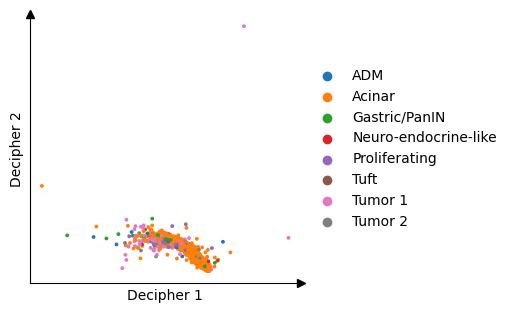

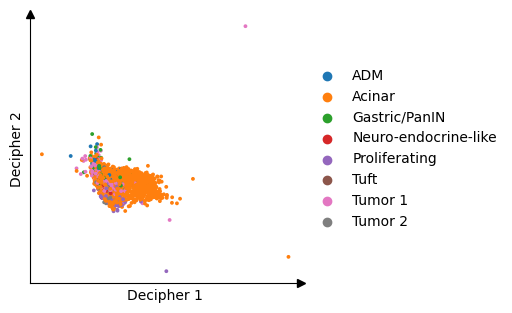

Epoch 2 | train elbo: 20418659974777.78 | val ll: 17779.16:   2%|▏         | 2/100 [10:20<6:03:23, 222.48s/it]2023-12-01 15:15:55,667 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:15:55,673 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3

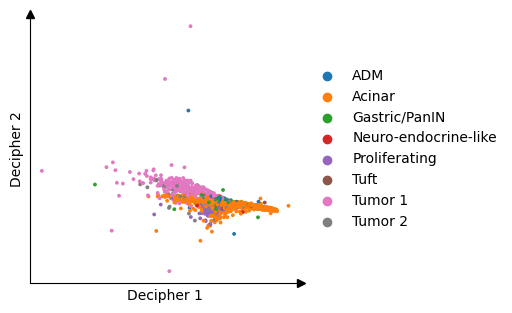

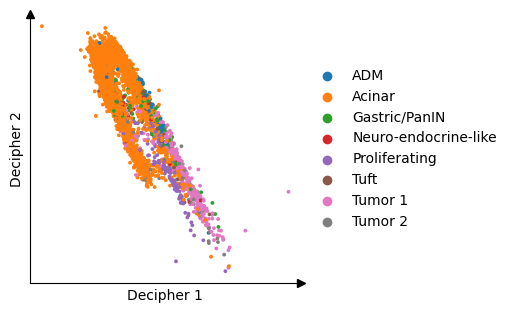

Epoch 3 | train elbo: 59966.81 | val ll: 17626.88:   3%|▎         | 3/100 [13:18<5:33:33, 206.32s/it]         2023-12-01 15:18:51,216 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:18:51,223 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3

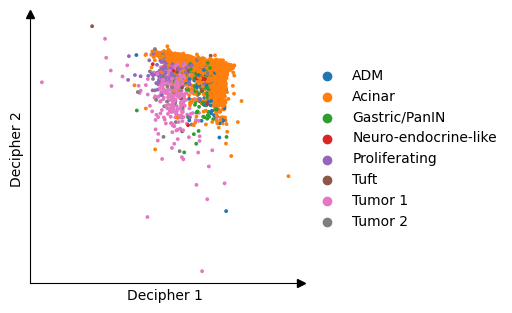

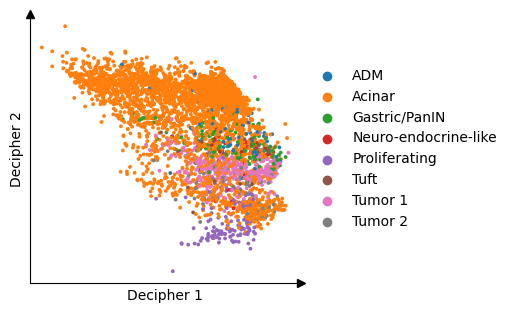

Epoch 4 | train elbo: 59327.45 | val ll: 17534.21:   4%|▍         | 4/100 [15:54<5:10:39, 194.16s/it]2023-12-01 15:21:18,974 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:21:18,977 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-p

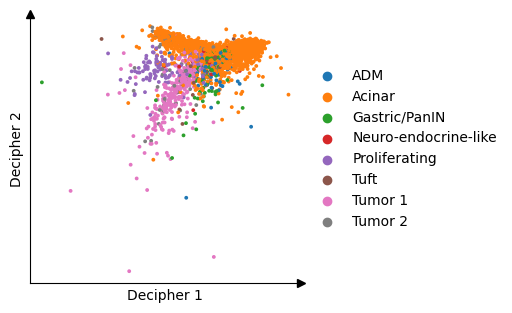

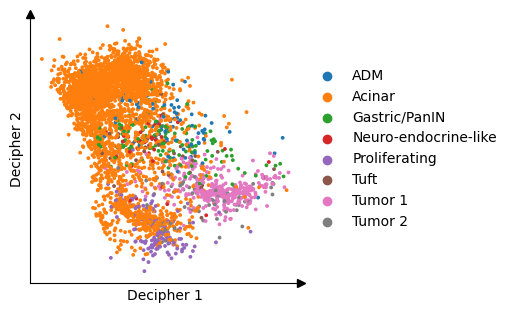

Epoch 5 | train elbo: 58977.06 | val ll: 17486.08:   5%|▌         | 5/100 [17:37<4:40:49, 177.36s/it]2023-12-01 15:23:03,122 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:23:03,128 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-p

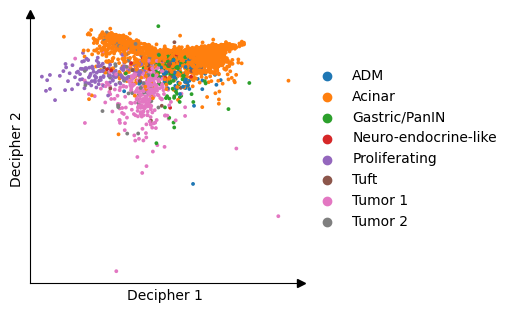

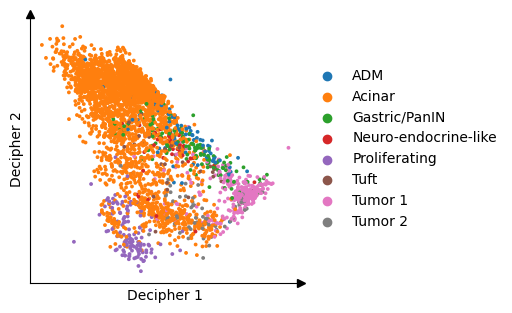

Epoch 6 | train elbo: 58797.79 | val ll: 17451.75:   6%|▌         | 6/100 [19:19<3:58:51, 152.47s/it]2023-12-01 15:24:46,858 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:24:46,861 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-p

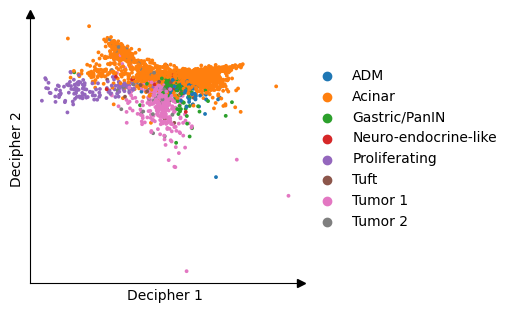

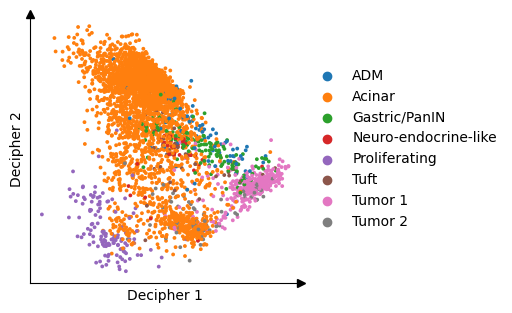

Epoch 7 | train elbo: 58683.30 | val ll: 17422.05:   7%|▋         | 7/100 [21:17<3:31:37, 136.54s/it]2023-12-01 15:26:44,433 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:26:44,436 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-p

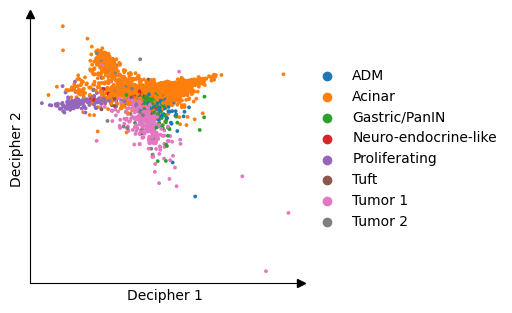

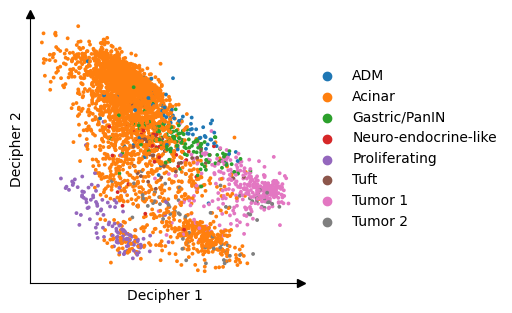

Epoch 8 | train elbo: 58587.68 | val ll: 17397.23:   8%|▊         | 8/100 [22:56<3:20:05, 130.49s/it]2023-12-01 15:28:20,829 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:28:20,832 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-p

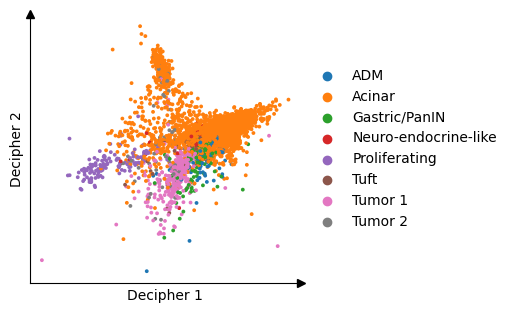

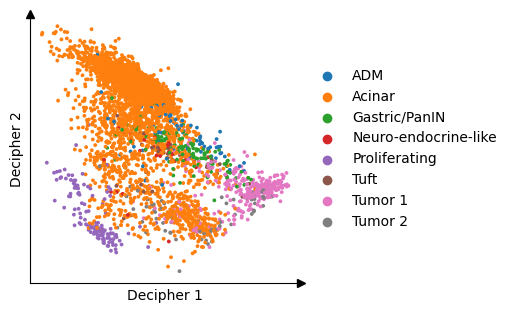

Epoch 9 | train elbo: 58500.85 | val ll: 17397.32:   9%|▉         | 9/100 [24:36<3:01:45, 119.84s/it]2023-12-01 15:30:01,789 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:30:01,797 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-p

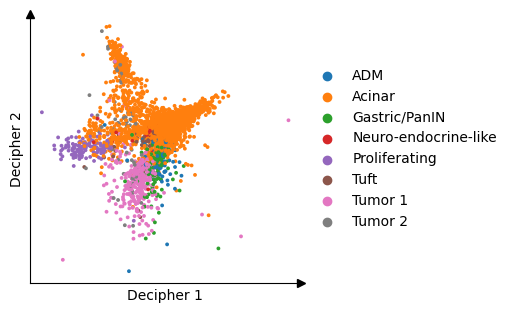

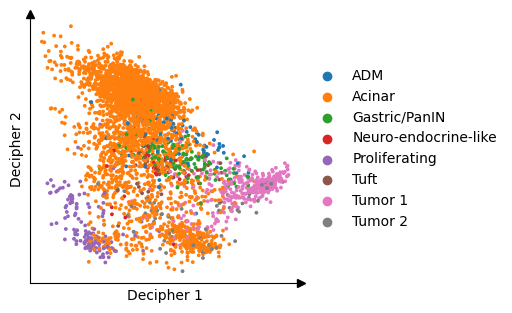

Epoch 10 | train elbo: 58398.21 | val ll: 17350.31:  10%|█         | 10/100 [26:07<2:51:01, 114.01s/it]2023-12-01 15:31:31,513 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:31:31,516 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site

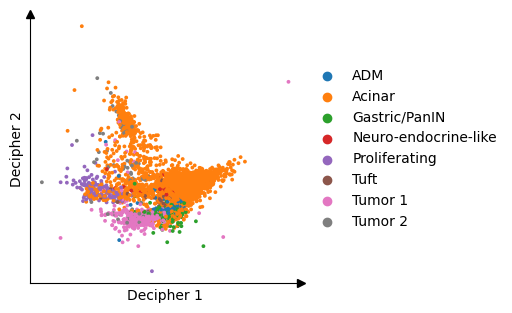

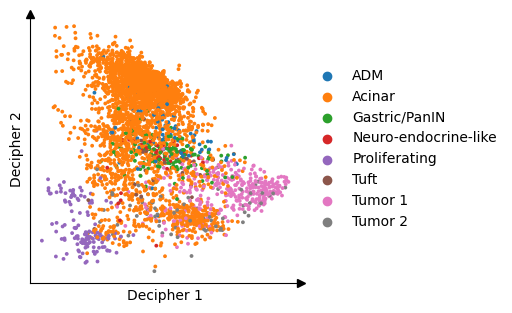

Epoch 11 | train elbo: 58334.99 | val ll: 17346.55:  11%|█         | 11/100 [27:38<2:38:05, 106.58s/it]2023-12-01 15:33:02,586 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:33:02,592 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site

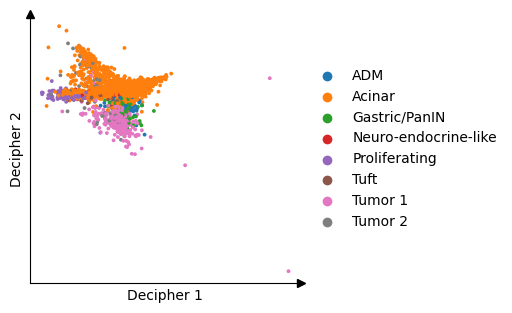

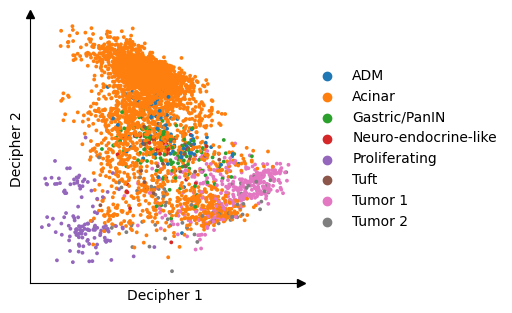

Epoch 12 | train elbo: 58270.39 | val ll: 17334.00:  12%|█▏        | 12/100 [29:09<2:29:23, 101.86s/it]2023-12-01 15:34:33,919 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:34:33,921 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site

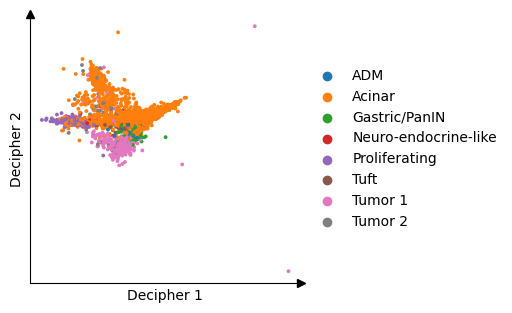

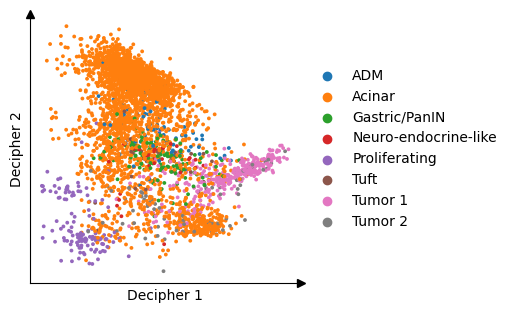

Epoch 13 | train elbo: 58224.40 | val ll: 17317.50:  13%|█▎        | 13/100 [30:41<2:23:04, 98.68s/it] 2023-12-01 15:36:05,929 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:36:05,933 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site

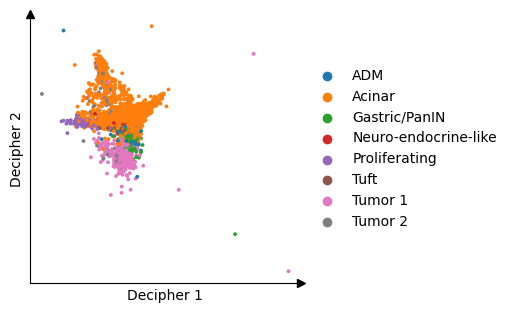

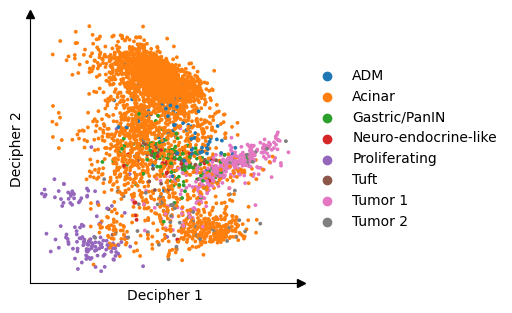

Epoch 14 | train elbo: 58176.85 | val ll: 17319.24:  14%|█▍        | 14/100 [32:13<2:18:32, 96.66s/it]2023-12-01 15:37:38,342 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:37:38,346 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

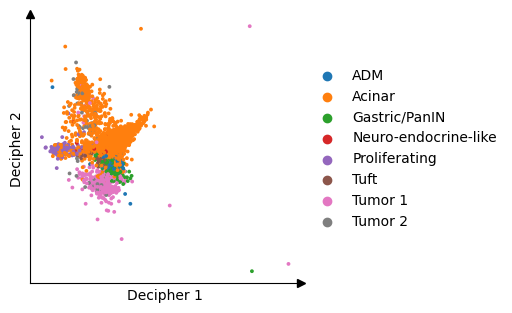

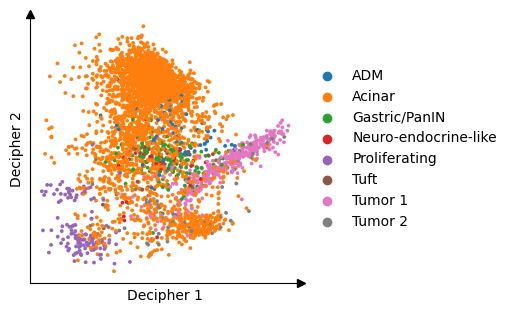

Epoch 15 | train elbo: 58131.45 | val ll: 17319.19:  15%|█▌        | 15/100 [33:45<2:15:07, 95.38s/it]2023-12-01 15:39:10,498 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:39:10,502 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

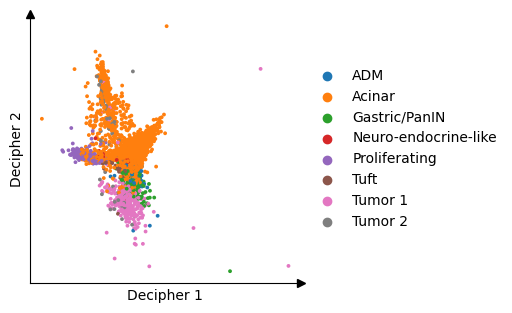

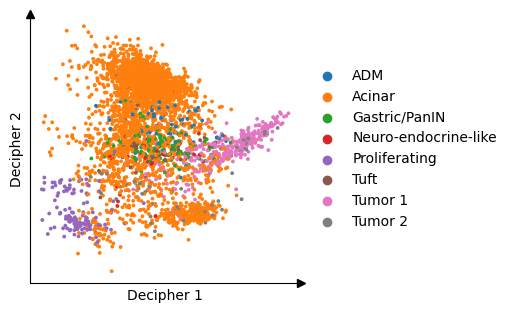

Epoch 16 | train elbo: 58087.23 | val ll: 17318.28:  16%|█▌        | 16/100 [35:25<2:12:10, 94.41s/it]2023-12-01 15:40:50,853 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:40:50,867 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

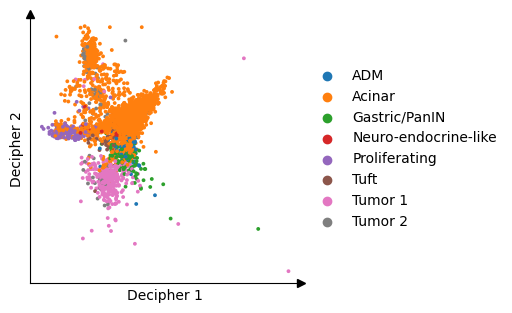

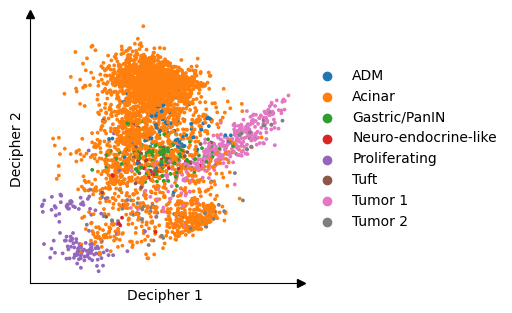

Epoch 17 | train elbo: 58064.49 | val ll: 17314.48:  17%|█▋        | 17/100 [37:02<2:13:04, 96.20s/it]2023-12-01 15:42:27,009 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:42:27,012 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

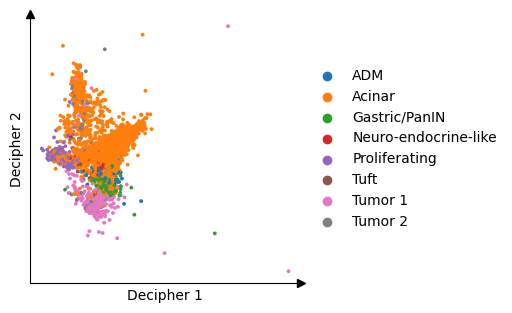

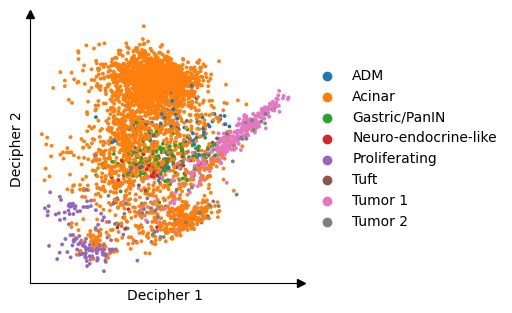

Epoch 18 | train elbo: 58034.11 | val ll: 17291.57:  18%|█▊        | 18/100 [38:34<2:11:26, 96.18s/it]2023-12-01 15:43:59,054 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:43:59,057 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

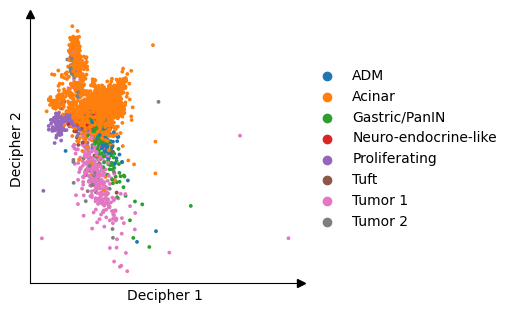

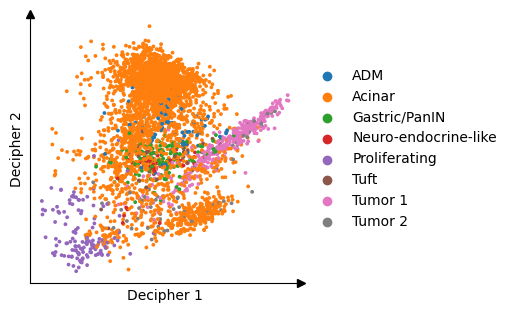

Epoch 19 | train elbo: 58352.20 | val ll: 17291.50:  19%|█▉        | 19/100 [40:10<2:08:09, 94.93s/it]2023-12-01 15:45:34,926 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:45:34,930 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

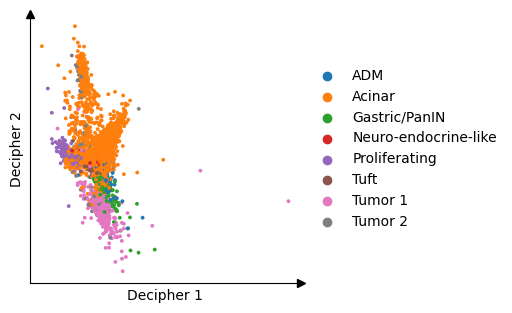

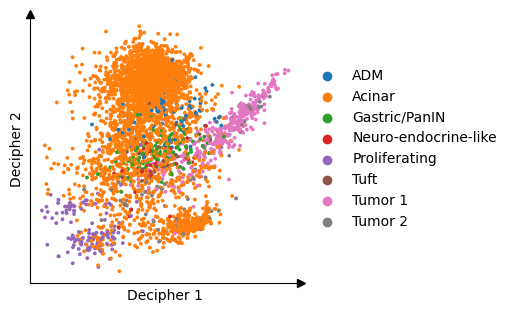

Epoch 20 | train elbo: 57996.04 | val ll: 17294.70:  20%|██        | 20/100 [41:47<2:06:57, 95.22s/it]2023-12-01 15:47:11,899 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:47:11,902 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

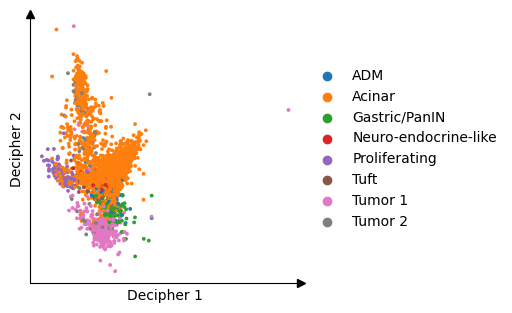

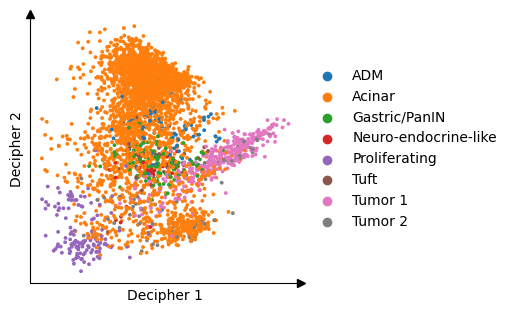

Epoch 21 | train elbo: 58124.90 | val ll: 17308.20:  21%|██        | 21/100 [43:28<2:06:03, 95.74s/it]2023-12-01 15:48:53,469 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:48:53,471 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

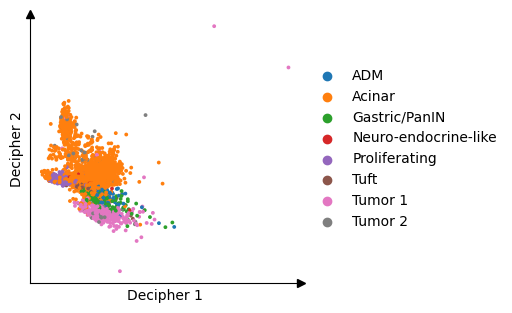

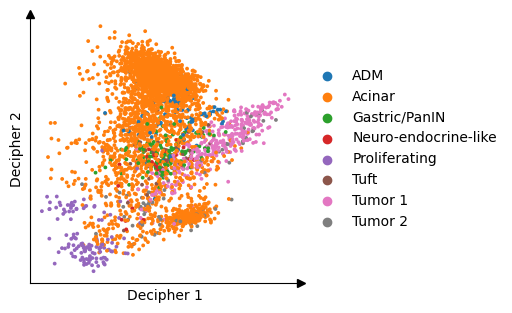

Epoch 22 | train elbo: 58007.66 | val ll: 17282.53:  22%|██▏       | 22/100 [45:05<2:06:44, 97.49s/it]2023-12-01 15:50:30,386 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:50:30,392 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

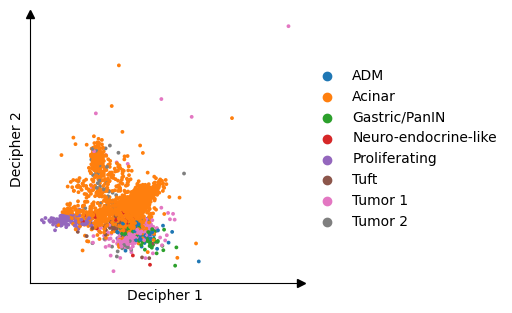

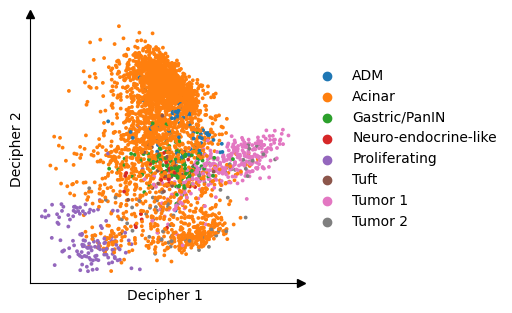

Epoch 23 | train elbo: 57974.14 | val ll: 17299.38:  23%|██▎       | 23/100 [46:38<2:04:53, 97.32s/it]2023-12-01 15:52:03,170 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:52:03,173 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

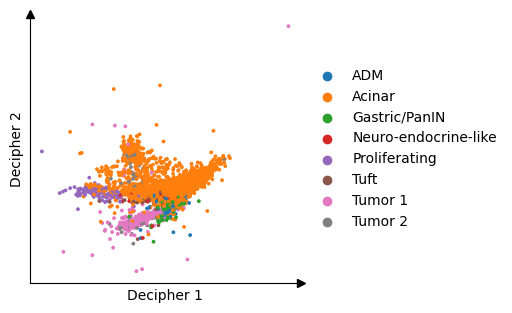

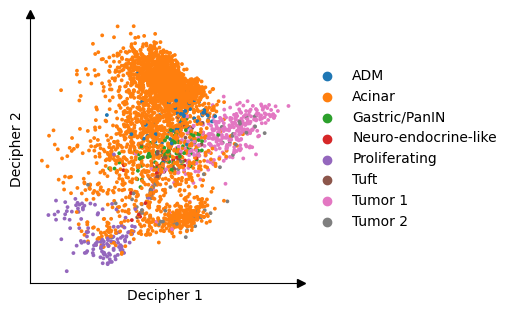

Epoch 24 | train elbo: 57950.64 | val ll: 17299.81:  24%|██▍       | 24/100 [48:17<2:01:32, 95.96s/it]2023-12-01 15:53:43,182 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:53:43,185 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

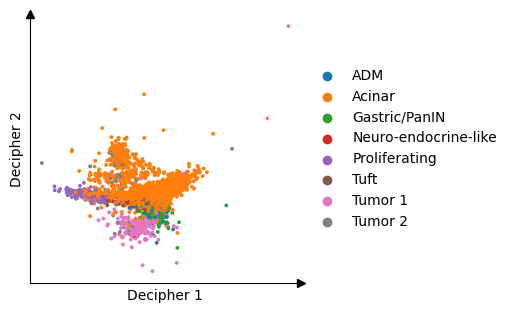

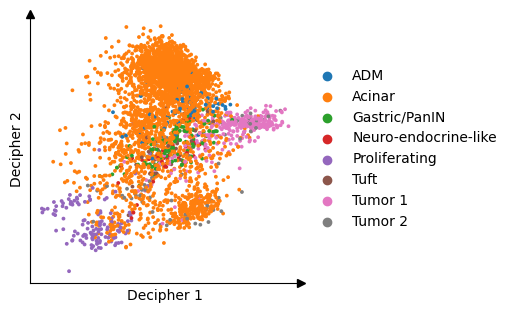

Epoch 25 | train elbo: 57927.56 | val ll: 17267.69:  25%|██▌       | 25/100 [49:57<2:01:28, 97.18s/it]2023-12-01 15:55:23,848 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:55:23,850 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

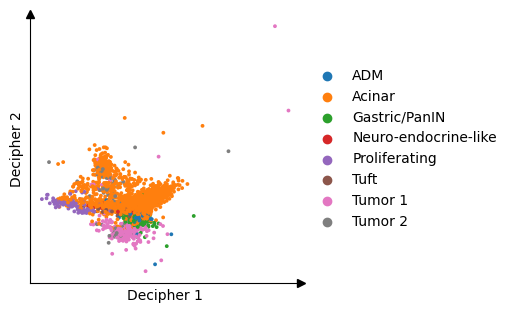

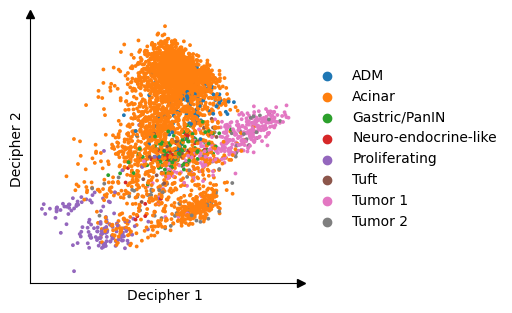

Epoch 26 | train elbo: 57897.66 | val ll: 17279.57:  26%|██▌       | 26/100 [51:40<2:01:08, 98.23s/it]2023-12-01 15:57:06,484 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:57:06,488 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

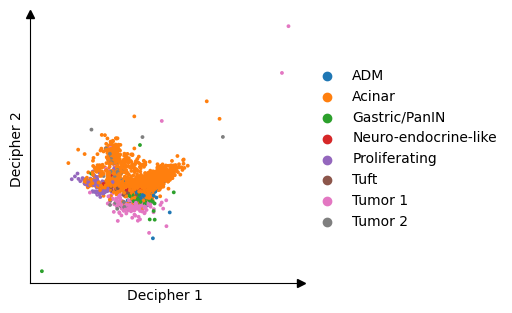

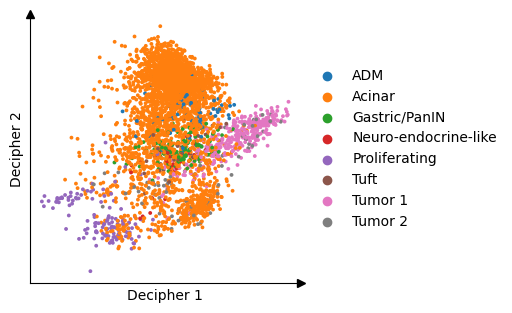

Epoch 27 | train elbo: 57880.78 | val ll: 17271.54:  27%|██▋       | 27/100 [53:16<2:01:11, 99.61s/it]2023-12-01 15:58:41,948 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:58:41,959 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

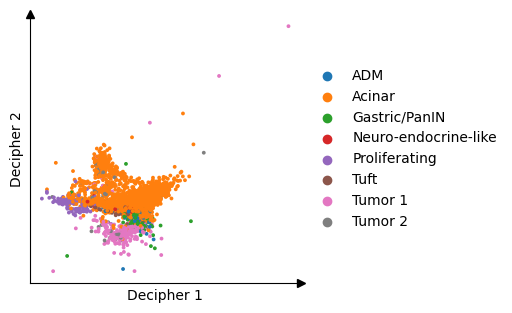

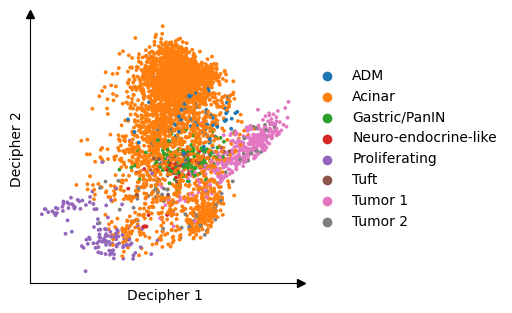

Epoch 28 | train elbo: 57869.69 | val ll: 17259.61:  28%|██▊       | 28/100 [54:51<1:57:57, 98.30s/it]2023-12-01 16:00:16,289 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 16:00:16,292 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-

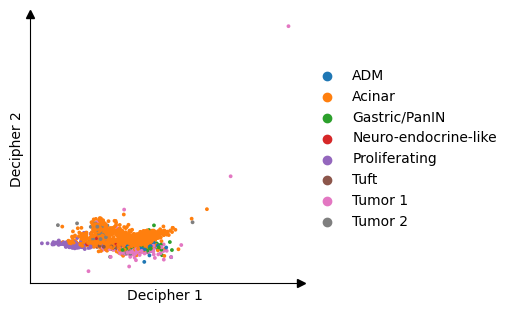

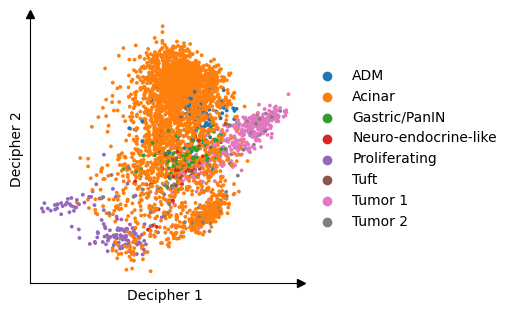

Epoch 28 | train elbo: 57869.69 | val ll: 17259.61:  29%|██▉       | 29/100 [55:00<1:54:55, 97.13s/it]/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/pyro/poutine/trace_struct.py:285: UserWarning: Encountered NaN: log_prob_sum at site 'vs'
  warn_if_nan(
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
Epoch 28 | train elbo: 57869.69 | val ll: 17259.61:  29%|██▉       | 29/100 [55:10<2:15:04, 114.15s/it]


ValueError: Expected parameter loc (Tensor of shape (64, 20)) of distribution Normal(loc: torch.Size([64, 20]), scale: torch.Size([64, 20])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<SliceBackward0>)
                                    Trace Shapes:              
                                     Param Sites:              
      decipher$$$decoder_vx_to_zx.layers.0.weight     64      2
        decipher$$$decoder_vx_to_zx.layers.0.bias            64
      decipher$$$decoder_vx_to_zx.layers.1.weight     20     64
        decipher$$$decoder_vx_to_zx.layers.1.bias            20
 decipher$$$decoder_vx_to_zx.batch_norms.0.weight            64
   decipher$$$decoder_vx_to_zx.batch_norms.0.bias            64
      decipher$$$decoder_vy_to_zy.layers.0.weight     64      2
        decipher$$$decoder_vy_to_zy.layers.0.bias            64
      decipher$$$decoder_vy_to_zy.layers.1.weight     20     64
        decipher$$$decoder_vy_to_zy.layers.1.bias            20
 decipher$$$decoder_vy_to_zy.batch_norms.0.weight            64
   decipher$$$decoder_vy_to_zy.batch_norms.0.bias            64
      decipher$$$decoder_vs_to_zs.layers.0.weight     64      2
        decipher$$$decoder_vs_to_zs.layers.0.bias            64
      decipher$$$decoder_vs_to_zs.layers.1.weight     20     64
        decipher$$$decoder_vs_to_zs.layers.1.bias            20
 decipher$$$decoder_vs_to_zs.batch_norms.0.weight            64
   decipher$$$decoder_vs_to_zs.batch_norms.0.bias            64
     decipher$$$decoder_zxzs_to_x.layers.0.weight  21821     20
       decipher$$$decoder_zxzs_to_x.layers.0.bias         21821
       decipher$$$decoder_zy_to_y.layers.0.weight 258561     10
         decipher$$$decoder_zy_to_y.layers.0.bias        258561
     decipher$$$encoder_x_to_zxzs.layers.0.weight    128  21821
       decipher$$$encoder_x_to_zxzs.layers.0.bias           128
     decipher$$$encoder_x_to_zxzs.layers.1.weight     40    128
       decipher$$$encoder_x_to_zxzs.layers.1.bias            40
decipher$$$encoder_x_to_zxzs.batch_norms.0.weight           128
  decipher$$$encoder_x_to_zxzs.batch_norms.0.bias           128
       decipher$$$encoder_y_to_zy.layers.0.weight    128 258561
         decipher$$$encoder_y_to_zy.layers.0.bias           128
       decipher$$$encoder_y_to_zy.layers.1.weight     20    128
         decipher$$$encoder_y_to_zy.layers.1.bias            20
  decipher$$$encoder_y_to_zy.batch_norms.0.weight           128
    decipher$$$encoder_y_to_zy.batch_norms.0.bias           128
       decipher$$$encoder_zx_to_v.layers.0.weight    128  21831
         decipher$$$encoder_zx_to_v.layers.0.bias           128
       decipher$$$encoder_zx_to_v.layers.1.weight      4    128
         decipher$$$encoder_zx_to_v.layers.1.bias             4
  decipher$$$encoder_zx_to_v.batch_norms.0.weight           128
    decipher$$$encoder_zx_to_v.batch_norms.0.bias           128
      decipher$$$encoder_zsy_to_v.layers.0.weight    128 258581
        decipher$$$encoder_zsy_to_v.layers.0.bias           128
      decipher$$$encoder_zsy_to_v.layers.1.weight      4    128
        decipher$$$encoder_zsy_to_v.layers.1.bias             4
 decipher$$$encoder_zsy_to_v.batch_norms.0.weight           128
   decipher$$$encoder_zsy_to_v.batch_norms.0.bias           128
                                    Sample Sites:              
                                       batch dist             |
                                            value     64      |

In [35]:
config = DecipherConfig_withATAC(
    dim_genes = pdac_rna.shape[1],
    dim_atac= pdac_atac.shape[1])
decipherATAC_train(
    pdac_rna,
    pdac_atac,
    decipher_config=DecipherConfig_withATAC(),
    plot_every_k_epoch=1,
    plot_kwargs=dict(
        color=[
         "predicted.id"
        ])
)


In [53]:
pdac_atac

AnnData object with n_obs × n_vars = 3988 × 258561
    obs: 'orig.ident', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nCount_ATAC', 'nFeature_ATAC', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'pct_reads_in_peaks', 'blacklist_ratio', 'ATAC_snn_res.1.2', 'seurat_clusters', 'predicted.id', 'prediction.score.B.cell', 'prediction.score.Endothelial', 'prediction.score.Ductal', 'prediction.score.T.cell', 'prediction.score.Epi.Immune', 'prediction.score.Proliferating', 'prediction.score.Tumor.1', 'prediction.score.Macrophage', 'prediction.score.Acinar', 'prediction.score.Fib

In [59]:
sns.scatterplot(pdac_atac.obsm['decipher_vs'], cmap=pdac_atac.obs['predicted.id'])


/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Axes: >

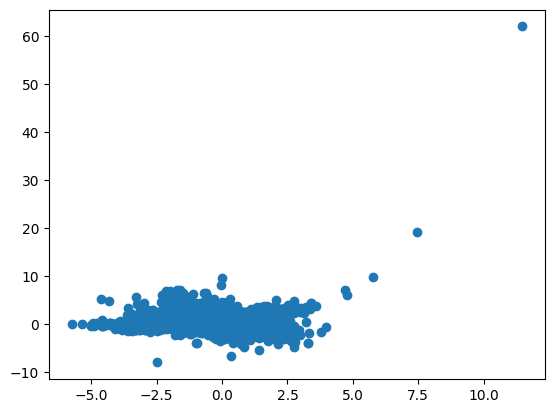

In [64]:
plt.scatter(pdac_atac.obsm['decipher_vs'][:,0], pdac_atac.obsm['decipher_vs'][:,1])
plt.show()

In [65]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x: 'float | ArrayLike', y: 'float | ArrayLike', s: 'float | ArrayLike | None' = None, c: 'ArrayLike | Sequence[ColorType] | ColorType | None' = None, marker: 'MarkerType | None' = None, cmap: 'str | Colormap | None' = None, norm: 'str | Normalize | None' = None, vmin: 'float | None' = None, vmax: 'float | None' = None, alpha: 'float | None' = None, linewidths: 'float | Sequence[float] | None' = None, *, edgecolors: "Literal['face', 'none'] | ColorType | Sequence[ColorType] | None" = None, plotnonfinite: 'bool' = False, data=None, **kwargs) -> 'PathCollection'
    A scatter plot of *y* vs. *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : float or array-like, shape (n, )
        The data positions.
    
    s : float or array-like, shape (n, ), optional
        The marker size in points**2 (typographic points are 1/72 in.).
        Default is ``rcParams['lines.markersize'] ** 2``.
    


## Decipher plot (no modif)


Add variance contour plot. 

In [ ]:
import numpy as np
import scanpy as sc
from matplotlib import pyplot as plt


def decipher_z(
    adata,
    basis="decipher_v",
    decipher_z_key="decipher_z",
    subset_of_zs=None,
    **kwargs,
):
    """Plot the Decipher v space colored by each dimension of the Decipher z space.

    Parameters
    ----------
    adata : sc.AnnData
        The annotated data matrix.
    basis : str, default "decipher_v"
        The basis to use for the plot.
    decipher_z_key : str, default "decipher_z"
        The key in `adata.obsm` where the decipher z space is stored.
    subset_of_zs : list of int, optional
        The dimensions of the decipher z space to plot. If None, plot all dimensions.
    **kwargs : dict, optional
        Additional arguments passed to `sc.pl.embedding`.

    Returns
    -------
    fig : matplotlib.pyplot.Figure
        The matplotlib figure.
    """
    dim_z = adata.obsm[decipher_z_key].shape[1]
    for i in range(dim_z):
        adata.obs["z%d" % (i + 1)] = adata.obsm[decipher_z_key][:, i]

    if subset_of_zs is None:
        subset_of_zs = list(range(1, dim_z + 1))

    return sc.pl.embedding(
        adata,
        basis=basis,
        color=[f"z{i}" for i in subset_of_zs],
        vmax=lambda xs: np.quantile(xs, 0.99),
        vmin=lambda xs: np.quantile(xs, 0.01),
        color_map="cool_r",
        frameon=False,
        show=False,
        sort_order=False,
        return_fig=True,
        **kwargs,
    )


def decipher(
    adata,
    color=None,
    palette=None,
    ncols=2,
    subsample_frac=1.0,
    title="",
    basis="decipher_v",
    x_label="Decipher 1",
    y_label="Decipher 2",
    axis_type="arrow",
    figsize=(3.5, 3.5),
    vmax=lambda xs: np.quantile(xs[~np.isnan(xs)], 0.99),
    **kwargs,
):
    """Plot the Decipher v space.

    Parameters
    ----------
    adata : sc.AnnData
        The annotated data matrix.
    color : str or list of str
        Keys for annotations of cells, given to `sc.pl.embedding`.
    palette : dict, optional
        A dictionary mapping color keys to colors.
    ncols : int, default 2
        Number of columns in the plot.
    subsample_frac : float, default 1.0
        Fraction of cells to plot. Useful for large datasets.
    title : str, default ""
        Title of the plot. Only used if `color` is a single key, otherwise the title for each
        subplot is set automatically to the name of the color key.
    basis : str, default "decipher_v"
        The basis to use for the plot.
    x_label : str, default "Decipher 1"
        The label for the x-axis.
    y_label : str, default "Decipher 2"
        The label for the y-axis.
    axis_type : str, default "arrow"
        The type of axis to use. Can be "arrow", "line", or "none".
        If "arrow", the axes are drawn as arrows, with no top or right spines.
        If "line", the axes are drawn as lines, with all spines.
        If "none", no axes are drawn.
    figsize : tuple, default (3.5, 3.5)
        The size of the figure.
    vmax : function, optional
        A function that takes a numpy array and returns a float. Used to set the maximum value of
        the colorbar. By default, the 99th percentile of the data is used.
    **kwargs : dict, optional
        Additional arguments passed to `sc.pl.embedding`.

    Returns
    -------
    fig : matplotlib.pyplot.Figure
        The matplotlib figure.

    See Also
    --------
    sc.pl.embedding

    """
    with plt.rc_context({"figure.figsize": figsize}):
        fig = sc.pl.embedding(
            sc.pp.subsample(adata, subsample_frac, copy=True),
            basis=basis,
            color=color,
            palette=palette,
            return_fig=True,
            frameon=(axis_type in ["line", "arrow"]),
            ncols=ncols,
            vmax=vmax if color is not None else None,
            **kwargs,
        )
    ax = fig.axes[0]
    if color is None or type(color) == str:
        color = [color]

    if len(color) == 1:
        ax.set_title(title)

    for i, ax in enumerate(fig.axes):
        if ax._label == "<colorbar>":
            continue
        if axis_type == "arrow":
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.plot(1, 0, ">k", transform=ax.transAxes, clip_on=False)
            ax.plot(0, 1, "^k", transform=ax.transAxes, clip_on=False)

        if axis_type != "none":
            if i % ncols == 0:
                ax.set_ylabel(y_label)
            else:
                ax.set_ylabel(None)
            if i // ncols == (len(color) - 1) // ncols:
                ax.set_xlabel(x_label)
            else:
                ax.set_xlabel(None)
    return fig
